## Preparation

In [1]:
#-*- coding : utf-8-*-
# coding:unicode_escape
import warnings
warnings.filterwarnings("ignore")

# import ST_utils
# import train_STAligner
import STAligner

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "D:\\anaconda\envs\STAligner\Lib\R"
os.environ['R_USER'] = "D:\\anaconda\envs\STAligner\Lib\site-packages\rpy2"

In [2]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

In [3]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(used_device)

cuda:0


In [4]:
# datasets = ['DAPI', 'FFPE']
# datasets = ['DAPI', 'FreshFrozen']
# datasets = ['FFPE', 'FreshFrozen']
datasets = ['DAPI', 'FFPE', 'FreshFrozen']
expriment_name = 'all_'
input_dir = 'G:/dataset/05-CoronalMouseBrain/input/'  # Replace it with your file path
output_dir = 'G:/dataset/05-CoronalMouseBrain/output/STAligner/'  # Replace it with your file path

rad_cutoff_dict = {'DAPI': 300, 'FFPE': 300, 'FreshFrozen': 150}  # neighbor 5-10

# try    num_cluster = 12
num_cluster = 12

In [5]:
# import pandas as pd
# section_ids = ['DAPI', 'FFPE','FreshFrozen']
# all_types = []
# for dataset in section_ids:
#     adata_label = pd.read_csv(input_dir + dataset + '/truth.csv', index_col=0)
#     types = adata_label['celltype'].unique().tolist()
#     print(len(types))
#     print(types)
#     all_types.extend(types)

# all_types = list(set(all_types))
# print(len(all_types))
# print(all_types)

## Load Data

In [6]:
Batch_list = []
adj_list = []
print(datasets)
remove_spot_batch_prefix_dict = {'DAPI': 'DAPI', 'FFPE': 'FFPE', 'FreshFrozen': 'Normal'}

for dataset in datasets:
    print(dataset)
    input_path = input_dir + dataset
    adata = sc.read_visium(path=input_path, count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")
    
    if dataset == 'FreshFrozen':
        adata.obsm['spatial'] = adata.obsm['spatial'].astype(np.int64)

    # # read the annotation
    # Ann_df = pd.read_csv(os.path.join(input_path, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
    # Ann_df.columns = ['Ground Truth']
    # Ann_df[Ann_df.isna()] = "unknown"
    # adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

    # # read the annotation
    adata_label = pd.read_csv(os.path.join(input_path, 'truth.csv'), index_col=0)
    # adata_label.index = [str.replace(str.replace(x, '.', '-'), adata_label['batch'][0] + '-', '') for x in adata_label.index]
    adata_label.index = [str.replace(str.replace(x, '.', '-'), remove_spot_batch_prefix_dict[dataset] + '-', '') for x in adata_label.index]
    # Ann_df['ground.truth'] = Ann_df['celltype'].replace('na', 'unknown')
    adata.obs['Ground Truth'] = adata_label.loc[adata.obs_names, 'celltype'].astype('category')

    # make spot name unique
    adata.obs_names = [x + '_' + dataset for x in adata.obs_names]

    # Constructing the spatial network
    STAligner.Cal_Spatial_Net(adata, rad_cutoff=rad_cutoff_dict[dataset]) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['DAPI', 'FFPE', 'FreshFrozen']
DAPI
------Calculating spatial graph...
The graph contains 16982 edges, 2903 cells.
5.8498 neighbors per cell on average.
FFPE
------Calculating spatial graph...
The graph contains 13176 edges, 2264 cells.
5.8198 neighbors per cell on average.
FreshFrozen
------Calculating spatial graph...
The graph contains 15708 edges, 2702 cells.
5.8135 neighbors per cell on average.


## Concat the scanpy objects for multiple slices

In [7]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=datasets)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (7869, 2300)


## Concat the spatial network for multiple slices

In [8]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(datasets)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

## Running STAligner

In [9]:
%%time
adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)

STAligner(
  (conv1): GATConv(2300, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2300, heads=1)
)
Pretrain with STAGATE...


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:46<00:00, 10.68it/s]


Train with STAligner...


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 20%|████████████████                                                                | 100/500 [00:11<00:37, 10.81it/s]

Update spot triplets at epoch 600


 40%|████████████████████████████████                                                | 200/500 [00:23<00:27, 10.76it/s]

Update spot triplets at epoch 700


 60%|████████████████████████████████████████████████                                | 300/500 [00:35<00:18, 10.75it/s]

Update spot triplets at epoch 800


 80%|████████████████████████████████████████████████████████████████                | 400/500 [00:48<00:09, 10.49it/s]

Update spot triplets at epoch 900


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:00<00:00,  8.21it/s]

CPU times: total: 1min 58s
Wall time: 1min 48s


# save embedding

In [10]:
# save embedding
np.savetxt(output_dir + expriment_name + '_cluster_' + str(num_cluster) + '_STAligner.csv', adata_concat.obsm['STAligner'], delimiter=",")
np.savetxt(output_dir + expriment_name + '_cluster_' + str(num_cluster) + '_STAGATE.csv', adata_concat.obsm['STAGATE'], delimiter=",")

## Clustering

In [11]:
adata_concat

AnnData object with n_obs × n_vars = 7869 × 2300
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'slice_name', 'batch_name'
    uns: 'edgeList'
    obsm: 'spatial', 'STAGATE', 'STAligner'

In [12]:
num_cluster = 12

In [13]:
from STAligner import ST_utils
ST_utils.mclust_R(adata_concat, num_cluster=num_cluster, used_obsm='STAligner')
adata_concat = adata_concat[adata_concat.obs['Ground Truth']!='unknown']

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [14]:
from sklearn.metrics import adjusted_rand_score as ari_score
print('mclust, ARI = %01.3f' % ari_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))

mclust, ARI = 0.316


## Visualization

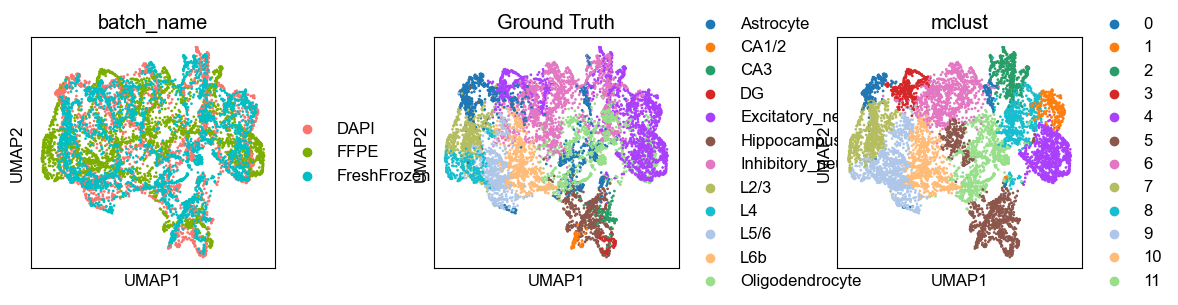

In [15]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(datasets, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]
adata_concat.obs['mclust'] = pd.Series(ST_utils.match_cluster_labels(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust'].values),
                                         index=adata_concat.obs.index, dtype='category')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata_concat, color=['batch_name', 'Ground Truth', 'mclust'], ncols=3,
           wspace=0.5, show=False)
plt.savefig(output_dir + expriment_name + '_umap.png', dpi=300)

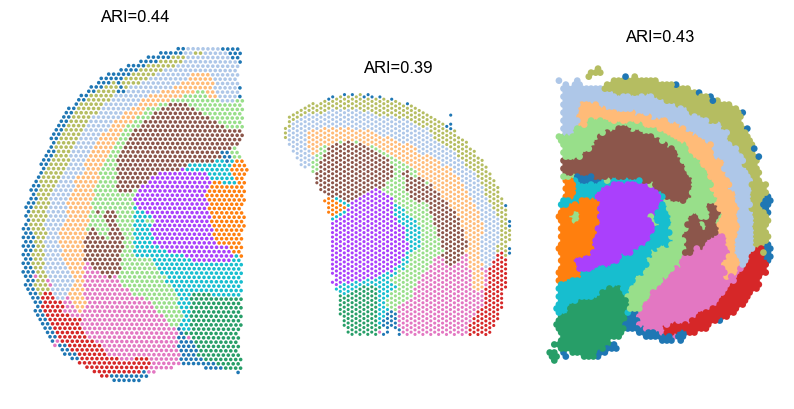

In [16]:
Batch_list = []
for section_id in datasets:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
ARI_list = []
for bb in range(len(Batch_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(1, len(Batch_list), figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
# _sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['mclust'], title=[''],
#                       legend_fontsize=12, show=False, ax=ax[3], frameon=False,
#                       spot_size=spot_size)
# _sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)

plt.savefig(output_dir + expriment_name + '_ARI.png', dpi=300)
plt.show()

# save h5ad

In [19]:
print(adata_concat.obs)
# adata_concat.obs = adata_concat.obs.drop('in_tissue', axis=1)
adata_concat.obs = adata_concat.obs.astype('string')
adata_concat.obs = adata_concat.obs.astype('object')
print(adata_concat.obs)
adata_concat.obs.to_csv(output_dir + expriment_name + 'meta.csv',sep=',') 

                               in_tissue array_row array_col  \
AAACAAGTATCTCCCA-1_DAPI                1        50       102   
AAACAGAGCGACTCCT-1_DAPI                1        14        94   
AAACAGTGTTCCTGGG-1_DAPI                1        73        43   
AAACATTTCCCGGATT-1_DAPI                1        61        97   
AAACCGGGTAGGTACC-1_DAPI                1        42        28   
...                                  ...       ...       ...   
TTGTTGTGTGTCAAGA-1_FreshFrozen         1        31        77   
TTGTTTCACATCCAGG-1_FreshFrozen         1        58        42   
TTGTTTCATTAGTCTA-1_FreshFrozen         1        60        30   
TTGTTTCCATACAACT-1_FreshFrozen         1        45        27   
TTGTTTGTGTAAATTC-1_FreshFrozen         1         7        51   

                                     Ground Truth   slice_name   batch_name  \
AAACAAGTATCTCCCA-1_DAPI         Inhibitory_neuron         DAPI         DAPI   
AAACAGAGCGACTCCT-1_DAPI                 Astrocyte         DAPI         DA

In [18]:
print(type(adata_concat))
print(adata_concat.obsm)
print(adata_concat)

#  tuple 不能保存为h5ad
adata_concat.uns['edgeList'] = list(adata_concat.uns['edgeList'])

print(adata_concat.isbacked)
adata_concat.filename = output_dir + expriment_name + '.h5ad'
print(adata_concat.isbacked)

<class 'anndata._core.anndata.AnnData'>
AxisArrays with keys: spatial, STAGATE, STAligner, X_umap
AnnData object with n_obs × n_vars = 7869 × 2300
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'slice_name', 'batch_name', 'mclust'
    uns: 'edgeList', 'neighbors', 'umap', 'batch_name_colors', 'Ground Truth_colors', 'mclust_colors'
    obsm: 'spatial', 'STAGATE', 'STAligner', 'X_umap'
    obsp: 'distances', 'connectivities'
False
True
